In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
from data._utils import create_combined_dataset, split_combined_dataset
from train._utils import compute_loss_vectorized
from models._main import get_model
from omegaconf import OmegaConf
from utils import DEVICE

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [65]:
log_dir = '/home/lrvnc/Projects/worm-graph/logs/results/TS_LSTM_08_22/exp0'

# When the train loop is over, load the train dataset information to retrieve the seq_len and num_train_samples
# It assumes that all worms have the same seq_len and num_train_samples (as it is in the current implementation)
train_dataset_info = pd.read_csv(os.path.join(log_dir, 'dataset', 'train_dataset_info.csv'))
#!seq_len = int(train_dataset_info['train_seq_len'].values[0])
#!num_train_samples = int(train_dataset_info['num_train_samples'].values[0])
#!k_splits = int(train_dataset_info['k_splits'].values[0])
tau = 1 #!int(train_dataset_info['tau'].values[0])
#!use_residual = int(train_dataset_info['use_residual'].values[0])
#!smooth_data = int(train_dataset_info['smooth_data'].values[0])

train_dataset_names = train_dataset_info['dataset'].unique().tolist()

# List of datasets and worms to be analyzed
analysis_config = OmegaConf.load('/home/lrvnc/Projects/worm-graph/configs/submodule/analysis.yaml').analysis
datasets_and_worms = analysis_config.validation.experimental_datasets

# Loss metrics
val_running_base_loss = 0
val_running_loss = 0

dataset_val_loss = []
dataset_val_baseline = []

for dataset, worms_to_use in datasets_and_worms.items():

    # Skip some datasets
    if worms_to_use is None:
        dataset_val_loss.append(0)
        dataset_val_baseline.append(0)
        continue

    experimental_datasets = {dataset: worms_to_use}
    combined_dataset, _ = create_combined_dataset(experimental_datasets=experimental_datasets,
                                                  num_named_neurons='all')
    _, val_dataset, _ = split_combined_dataset(combined_dataset=combined_dataset,
                                               k_splits=2, #! changeee
                                               num_train_samples=32,
                                               num_val_samples=32, # use the same number of samples as in the train dataset
                                               seq_len=120,
                                               tau=1,
                                               use_residual=False,
                                               smooth_data=True,
                                               reverse=False
                                               )
    
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    # Load the model
    model_chkpt = os.path.join(log_dir, 'train', 'checkpoints', f'model_best.pt')
    model = get_model(OmegaConf.create({'use_this_pretrained_model': model_chkpt}))
    model.to(DEVICE)
    criterion = model.loss_fn()

    # Evaluation loop
    model.eval()

    with torch.no_grad():
        
        for batch_idx, (X_val, Y_val, masks_val, metadata_val) in enumerate(valloader):

            X_val = X_val.to(DEVICE)
            Y_val = Y_val.to(DEVICE)
            masks_val = masks_val.to(DEVICE)

            # If many-to-one prediction, select last time step. Else, many-to-many prediction.
            if analysis_config.validation.task == "many-to-one":
                y_base = X_val[:, -1, :].unsqueeze(1)  # Select last time step
                Y_val = Y_val[:, -1, :].unsqueeze(1)  # Select last time step
            else:
                y_base = X_val

            # Baseline model: identity model - predict that the next time step is the same as the current one.
            # This is the simplest model we can think of: predict that the next time step is the same as the current one
            # is better than predict any other random number.
            val_baseline = compute_loss_vectorized(loss_fn=criterion, X=y_base, Y=Y_val, masks=masks_val)

            # Model
            y_pred = model(X_val, masks_val, tau)

            if analysis_config.validation.task == "many-to-one":
                y_pred = y_pred[:, -1, :].unsqueeze(1)  # Select last time step
                
            val_loss = compute_loss_vectorized(loss_fn=criterion, X=y_pred, Y=Y_val, masks=masks_val)

            # Update running losses
            val_running_base_loss += val_baseline.item()
            val_running_loss += val_loss.item()


        # Store metrics
        dataset_val_loss.append(val_running_loss / len(valloader))
        dataset_val_baseline.append(val_running_base_loss / len(valloader))

        # Reset running losses
        val_running_base_loss = 0
        val_running_loss = 0

# Save losses in csv
losses = pd.DataFrame({'dataset': list(datasets_and_worms.keys()),
                          'val_loss': dataset_val_loss,
                            'val_baseline': dataset_val_baseline})

# Create analysis folder
os.makedirs(os.path.join(log_dir, 'analysis'), exist_ok=True)
losses.to_csv(os.path.join(log_dir, 'analysis', 'losses.csv'), index=False)

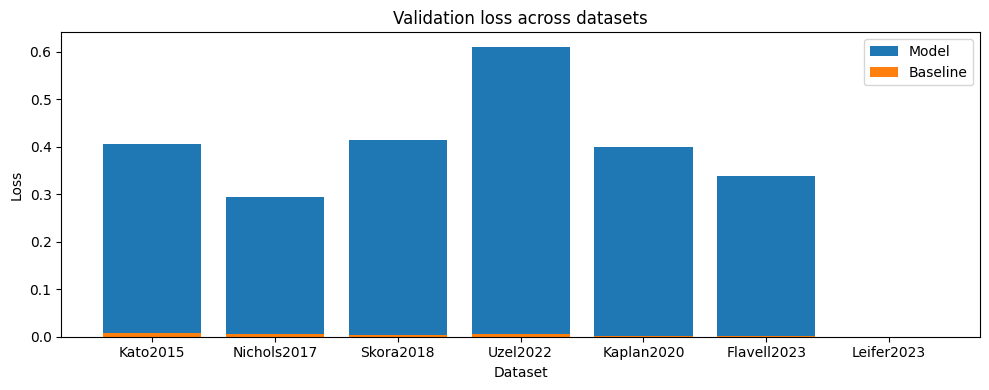

In [66]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(np.arange(len(dataset_val_loss)), dataset_val_loss, label='Model')
ax.bar(np.arange(len(dataset_val_baseline)), dataset_val_baseline, label='Baseline')
ax.set_xticks(np.arange(len(dataset_val_loss)))
# Xtics as dataset names
ax.set_xticklabels([key for key in datasets_and_worms.keys()])
ax.set_ylabel('Loss')
ax.set_xlabel('Dataset')
ax.set_title('Validation loss across datasets')
ax.legend()
plt.tight_layout()
plt.show()
